# Radiomic maps test


In [40]:
import nibabel as nib 
import matplotlib.pyplot as plt
import numpy as np
from radiomics import featureextractor
import SimpleITK as sitk
import time
import six 
import os 
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score


# Load data

In [2]:
img = nib.load('data/Patient01_mridian_ttt_1.nii').get_fdata()
print(img.shape)
mask = nib.load('data/Patient01_mridian_ttt_1_gtv.nii').get_fdata()

(276, 276, 80)


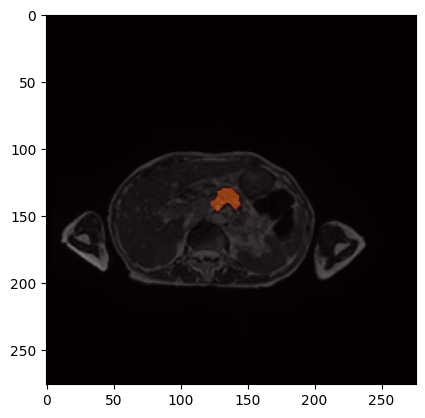

In [3]:
plt.figure()
plt.imshow(img[:,:,40], cmap='gray')
# plot mask on top of image
plt.imshow(mask[:, :, 40], vmin=0, vmax=2, cmap='hot', alpha=.5)


# Compute radiomic map

## Get masked image

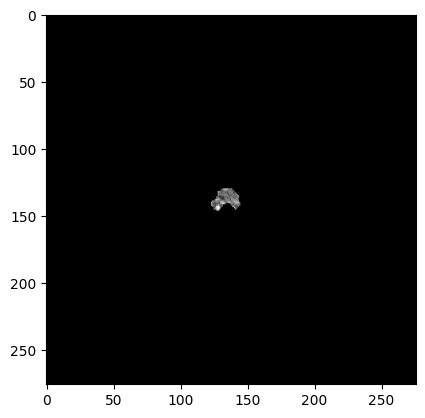

In [4]:
# keep only voxels of img where mask is 1 
img_masked = img * (mask == 1)
plt.figure()
plt.imshow(img_masked[:,:,40], cmap='gray')

In [5]:
print(np.min(img_masked), np.max(img_masked))

0.0 424.0


## Feature Map Extractor

In [27]:
def generate_feature_map(img_path, roi_path, parameter_path, store_path):
    """
        Generate specific feature map based on kernel Radius.
    Parameters
    ----------
    img_path: str, candidate image path;
    roi_path: str, candidate ROI path;
    parameter_path: str, .yaml parameter path;
    store_path: str;
    Returns
    -------
    """
    start_time = time.time()
    extractor = featureextractor.RadiomicsFeatureExtractor(parameter_path, store_path)
    # extractor.disableAllImageTypes()
    # extractor.disableAllFeatures()

    # compute features
    result = extractor.execute(img_path, roi_path, voxelBased=True)

    # save maps
    for key, val in six.iteritems(result):
        if isinstance(val, sitk.Image):
            sitk.WriteImage(val, os.path.join(store_path, key + '.nrrd'), True)
    print('Elapsed time: {} s'.format(time.time() - start_time))


In [20]:
image_path = 'data/Patient01_mridian_ttt_1.nii'
roi_path = 'data/Patient01_mridian_ttt_1_gtv.nii'

In [26]:
generate_feature_map(image_path, roi_path, 'params.yaml', 'outputs/')

FAILED: Traceback (most recent call last):
  File "/home/tachennf/miniconda3/envs/flothesis/lib/python3.8/site-packages/radiomics/base.py", line 238, in _calculateFeatures
    yield True, feature, getattr(self, 'get%sFeatureValue' % feature)()
  File "/home/tachennf/miniconda3/envs/flothesis/lib/python3.8/site-packages/radiomics/glcm.py", line 648, in getMCCFeatureValue
    Q_eigenValue = numpy.linalg.eigvals(Q.transpose((0, 3, 1, 2)))
  File "<__array_function__ internals>", line 200, in eigvals
  File "/home/tachennf/miniconda3/envs/flothesis/lib/python3.8/site-packages/numpy/linalg/linalg.py", line 1043, in eigvals
    _assert_finite(a)
  File "/home/tachennf/miniconda3/envs/flothesis/lib/python3.8/site-packages/numpy/linalg/linalg.py", line 195, in _assert_finite
    raise LinAlgError("Array must not contain infs or NaNs")
numpy.linalg.LinAlgError: Array must not contain infs or NaNs

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Elapsed time:  11.852442264556885


(23, 44, 30)


(<matplotlib.image.AxesImage at 0x7f974c911100>,
 <matplotlib.colorbar.Colorbar at 0x7f974c8eb490>)

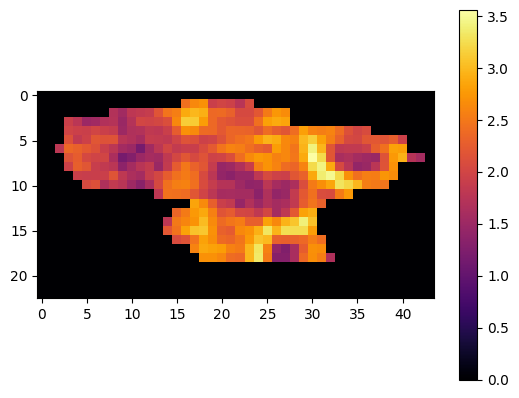

In [29]:
# display one nrrd map
feature_map = sitk.ReadImage('outputs/original_firstorder_Entropy.nrrd')
feature_map = sitk.GetArrayFromImage(feature_map)
print(feature_map.shape)
plt.figure()
plt.imshow(feature_map[:,:, 15], cmap='inferno'), plt.colorbar()

# Cluster feature map

In [47]:
def plot_silhouette(X, k, cluster_labels, centroids):
    
    # silhouette_score
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    #--- Do the ploting
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(14, 5)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

(1012,)


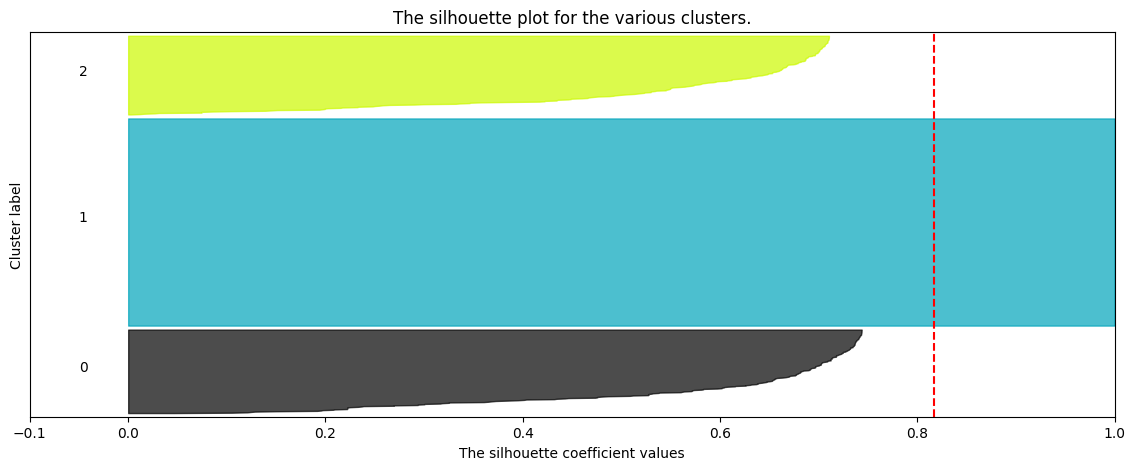

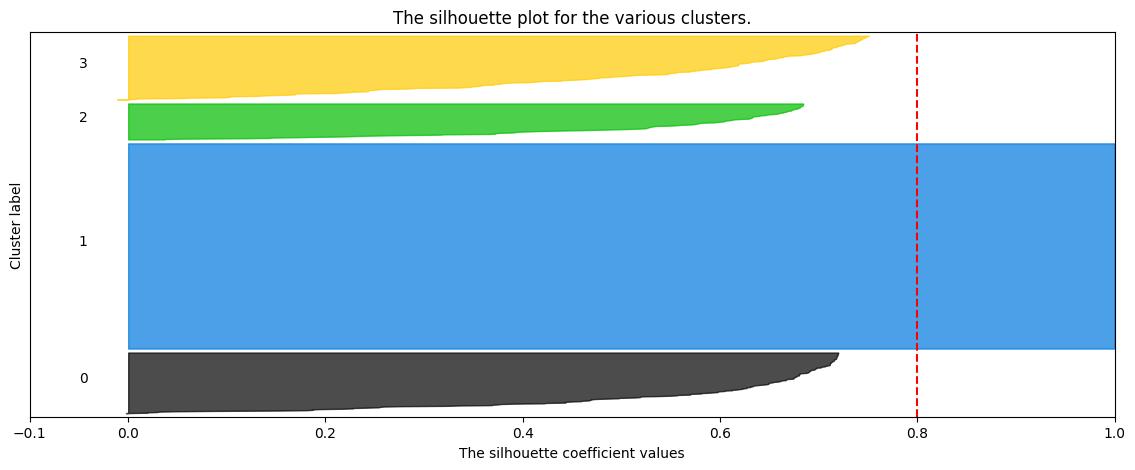

In [48]:
X = np.array(feature_map[:,:, 15])
print(X.flatten().shape)
x_shape = X.shape
for k in range(3, 5):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X.flatten().reshape(-1, 1))
    plot_silhouette(X.flatten().reshape(-1, 1), k, kmeans.labels_, kmeans.cluster_centers_)


In [62]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X.flatten().reshape(-1, 1))


(23, 44)


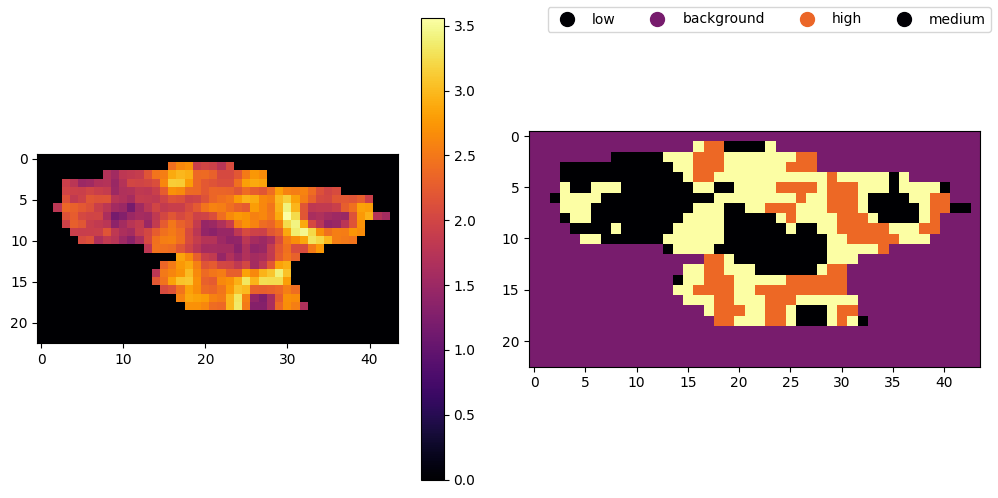

In [81]:
clustered_map = np.reshape(kmeans.labels_, x_shape)
print(clustered_map.shape)
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(X, cmap='inferno'), plt.colorbar()
plt.subplot(1, 2, 2), plt.imshow(clustered_map, cmap='inferno')
# plot a legend for the colors (four labels: background, low, medium, high)

# Create a color map for the legend
cmap = plt.get_cmap('inferno')
colors = [cmap(i) for i in [0, 0.33, 0.66, 1]]

# Create the legend
handles = [plt.Line2D([0], [0], color=c, marker='o', linestyle='',
                      markersize=10, label=f'label {i}') 
           for i, c in enumerate(colors)]

# Add legend to both subplots
fig.legend(handles, ['low', 'background', 'high', 'medium'], # the order has been modified to match the colors
           loc='upper right', ncol=4)

plt.tight_layout()

## Cluster map histogram 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


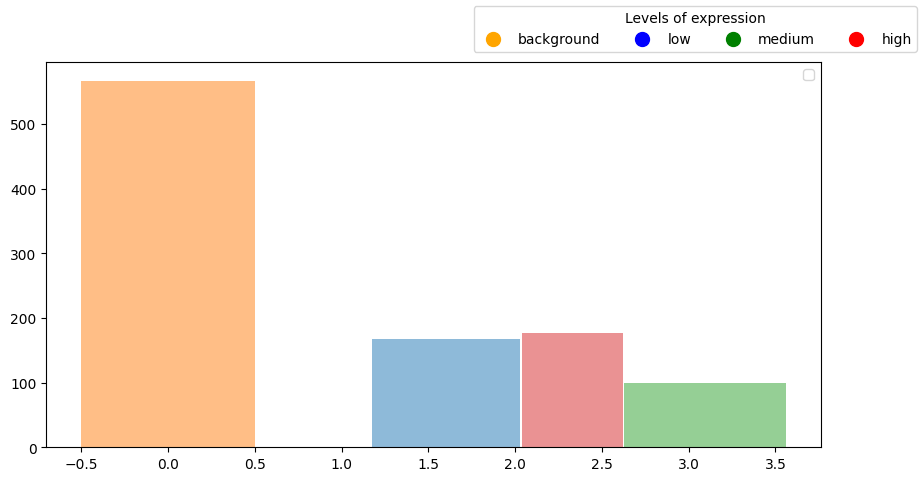

In [86]:
# show the distribution of the clusters other than with a histogram because I want each cluster to have its color

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(4):
    ax.hist(X[clustered_map == i], bins=1, alpha=0.5)
ax.legend()
# make an handle with the color used in the histogram
handles = [plt.Line2D([0], [0], color=c, marker='o', linestyle='',
                      markersize=10, label=f'label {i}') 
           for i, c in enumerate(['orange', 'blue', 'green', 'red'])]

# Add legend to both subplots
fig.legend(handles, ['background', 'low',  'medium', 'high'], # the order has been modified to match the colors
           loc='upper right', ncol=4, title='Levels of expression')
plt.show()